In [275]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import sys
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

sys.path.append('../')

In [276]:
from src.layers import CategoricalFeatureEmbedding, NumericalFeatureEmbedding, FeatureEmbedding, TransformerEncoder,MLP
from src.metrics import MultiClassConfusionMatrix, MultiClassMeanRecall, MultiClassMeanPrecision

In [277]:

# x_num = np.random.random(size=(10,5))
# n_objects, n_features = x_num.shape
# d_token = 3
# num_tokenizer = NumericalFeatureEmbedding(n_features, d_token, True, 'uniform')
# num_tokens = num_tokenizer(x_num)
# assert num_tokens.shape == (n_objects, n_features, d_token)


# x_cat = np.random.randint(0, 6, size=(10,2), dtype=np.int64)
# x_cat = tf.convert_to_tensor(x_cat)
# cat_tokenizer = CategoricalFeatureEmbedding(cardinalities=[6,6], dim_token=d_token)
# cat_tokens = cat_tokenizer(x_cat)
# assert cat_tokens.shape == (x_cat.shape[0], x_cat.shape[1], d_token)


# tf.concat([num_tokens,cat_tokens], axis=1)

In [303]:
# Implement model classes to facilitate building
# input preprocessing and evaluation.
# We use Functional API of keras to build models

class TabularTransformer(object):

    def __init__(
            self, 
            emb_dim=32, 
            tr_depth=6, 
            tr_heads=8, 
            tr_ff_dim=16, 
            tr_attn_dropout=0.1, 
            tr_ff_dropout=0.1,
            mlp_hidden_mults=[4,2],
            mlp_activation='relu'
        ):

        # embeddings parameters
        self.emb_dim = emb_dim

        # transformer parameters
        self.tr_depth = tr_depth
        self.tr_heads = tr_heads
        self.tr_ff_dim = tr_ff_dim
        self.tr_attn_dropout = tr_attn_dropout
        self.tr_ff_dropout = tr_ff_dropout
        
        # mlp parameters
        self.mlp_hidden_mults = mlp_hidden_mults
        self.mlp_activation = keras.layers.ReLU() if mlp_activation == 'relu' else mlp_activation


        self.model = None

    @classmethod
    def from_config(cls, config):
        return cls(**config)


    def _compile_model(self, learning_rate=1e-4):
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
        
        if self.output_dim > 1:
            loss = 'categorical_crossentropy'
            # loss = tf.keras.losses.CategoricalCrossentropy()
            # metrics = ['accuracy']
            metrics = [
                keras.metrics.CategoricalAccuracy(name='accuracy'),
            ]
        else:
            # loss = tf.keras.losses.MeanSquaredError()
            loss = 'mean_squared_error'
            metrics = [
                keras.metrics.MAE(name='mae'),
                keras.metrics.MAPE(name='mape'),
                keras.metrics.MSE(name='mse'),
            ]

        self.model.compile(optimizer=opt, loss=loss, metrics=metrics)


    def _fit_model(self, train_ds, val_ds, epochs=1):
        early_stop_callback = keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=10
        )
        callbacks = [early_stop_callback]
        history = self.model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)
        return history

    def _build_model(self, inputs):
        """
        Construct the model using functional API of keras.
        Requiers information about input layers.
        """

        all_inputs = inputs['inputs']
        cat_features = tf.keras.layers.Concatenate(name='categorical_features')(inputs['cat_features'])
        num_features = tf.keras.layers.Concatenate(name='numerical_features')(inputs['num_features'])

        x_num = keras.layers.LayerNormalization(name='layer_norm_num')(num_features)

        x_num_emb = NumericalFeatureEmbedding(num_features=self.n_num_features,dim_token=self.emb_dim)(num_features) 
        x_cat_emb = CategoricalFeatureEmbedding(cardinalities=self.cardinalities,dim_token=self.emb_dim)(cat_features)

        x_tr = tf.concat([x_num_emb,x_cat_emb], axis=1)

        for _ in range(0,self.tr_depth):
            x_tr = TransformerEncoder(
                embed_dim=(self.emb_dim), 
                num_heads=self.tr_heads, 
                ff_dim=self.tr_ff_dim, 
                ff_dropout=self.tr_ff_dropout,
                attn_dropout=self.tr_attn_dropout
                )(x_tr)

        x_emb = keras.layers.Flatten(name="flatten_embeddings")(x_tr)

        mlp_input = keras.layers.Concatenate(name="concat_num_emb")([x_num,x_emb])

        input_size = (self.emb_dim * len(self.cardinalities)) + ((self.emb_dim * self.n_num_features)) + self.n_num_features
        l = input_size // 8

        hidden_dimensions = list(map(lambda t: l * t, self.mlp_hidden_mults))

        # dim out sale de y
        all_dimensions = [input_size, *hidden_dimensions, self.output_dim]

        if self.mlp_activation is not None:
            mlp = MLP(all_dimensions, activation=self.mlp_activation)
        else:
            mlp = MLP(all_dimensions, activation=keras.layers.ReLU())

        mlp_outputs = mlp(mlp_input)
        
        if self.output_dim > 1:
            outputs = keras.activations.softmax(mlp_outputs)
        else:
            outputs = mlp_outputs

        self.model = keras.Model(inputs=all_inputs, outputs=outputs)
        
        return self


    def _fit_transform_label(self, y:pd.DataFrame):
        if y.dtype in [np.int16,np.int32,np.int64]:
            self.label_encoder = LabelEncoder()
            self.label_encoder.fit(np.ravel(y))
            self.output_dim = len(self.label_encoder.classes_)
        else:
            self.label_encoder = None
            self.output_dim = 1

        return self._transform_label(y)

    def _transform_label(self, y):
        if self.label_encoder is not None:
            encoded_y=self.label_encoder.transform(np.ravel(y))
            return np_utils.to_categorical(encoded_y)
        else:
            return y

    def _get_normalization_layer(self, name, dataset):
        normalizer = keras.layers.Normalization(axis=None,name=f"normalization_{name}")
        feature_ds = dataset.map(lambda x, y: x[name])
        normalizer.adapt(feature_ds)
        return normalizer

    def _get_category_encoding_layer(self, name, dataset, dtype, max_tokens=None):
    
        if dtype == 'string':
            index = keras.layers.StringLookup(max_tokens=max_tokens, name=f"encoding_{name}")
      
        else:
            index = keras.layers.IntegerLookup(max_tokens=max_tokens, oov_token=9999, name=f"encoding_{name}")

        feature_ds = dataset.map(lambda x, y: x[name])
        index.adapt(feature_ds)
        return index

    def _get_input_layers(self, dataset):
        all_inputs = []
        encoded_num_features = []
        encoded_cat_features = []

        cardinalities = []
        n_num_features = 0

        features_dtypes = dataset.element_spec[0]

        for name in features_dtypes:
            if features_dtypes[name].dtype in [tf.float64, tf.float32]:
                input_layer = tf.keras.Input(shape=(1,), name=name)
                prepro_layer = self._get_normalization_layer(name, dataset)
                encoded_feature = prepro_layer(input_layer)
                encoded_num_features.append(encoded_feature)

                n_num_features = n_num_features+1

            elif features_dtypes[name].dtype in [tf.int32, tf.int64]:
                input_layer = tf.keras.Input(shape=(1,), name=name,dtype='int64')
                prepro_layer = self._get_category_encoding_layer(name=name,dataset=dataset,dtype='integer')
                encoded_feature = prepro_layer(input_layer)
                encoded_cat_features.append(encoded_feature)

                cardinalities.append(len(prepro_layer.get_vocabulary()))

            elif features_dtypes[name].dtype in [tf.string]:
                input_layer = tf.keras.Input(shape=(1,), name=name, dtype='string')
                prepro_layer = self._get_category_encoding_layer(name=name,dataset=dataset, dtype='string')
                encoded_feature = prepro_layer(input_layer)
                encoded_cat_features.append(encoded_feature)

                cardinalities.append(len(prepro_layer.get_vocabulary()))

            all_inputs.append(input_layer)

        self.cardinalities = cardinalities
        self.n_num_features = n_num_features

        return {"inputs":all_inputs, "num_features":encoded_num_features, "cat_features":encoded_cat_features}


    def _preprocess_predict(self, X:pd.DataFrame):
        inputs = {name: tf.convert_to_tensor([value]) for name, value in X.items()}
        return tf.data.Dataset.from_tensor_slices(dict(inputs))

    def _preprocess_evaluate(self, X:pd.DataFrame, y:pd.DataFrame, batch_size=32):
        X = {key: np.array(value)[:,tf.newaxis] for key, value in X.items()}
        y = self._transform_label(y.values)
        ds = tf.data.Dataset.from_tensor_slices((dict(X), y))
        ds = ds.batch(batch_size)
        return ds

    def _preprocess_fit(self, X:pd.DataFrame, y:pd.DataFrame, eval_size=0.2, shuffle=True, batch_size=32):
        X, y = X.copy(), y.copy()
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=eval_size, random_state=1213, shuffle=shuffle)
        
        y_train = self._fit_transform_label(y_train.values)
        y_val = self._transform_label(y_val.values)
        
        X_train = {key: np.array(value)[:,tf.newaxis] for key, value in X_train.items()}
        train_ds = tf.data.Dataset.from_tensor_slices((dict(X_train), y_train))

        X_val = {key: np.array(value)[:,tf.newaxis] for key, value in X_val.items()}
        val_ds = tf.data.Dataset.from_tensor_slices((dict(X_val), y_val))

        train_ds = train_ds.batch(batch_size)
        val_ds = val_ds.batch(batch_size)

        return train_ds, val_ds



    def fit(self, X, y, eval_size=0.1, learning_rate=1e-4, epochs=1,shuffle=True, batch_size=32):
        # convert to dataset
        train_ds, val_ds = self._preprocess_fit(X, y, eval_size=eval_size, shuffle=shuffle, batch_size=batch_size)
    
        if self.model is None:
            # prepare input layers
            inputs = self._get_input_layers(train_ds)
            # build model    
            self._build_model(inputs)

        # compile model
        self._compile_model(learning_rate=learning_rate)
        # fit model
        self._fit_model(train_ds, val_ds, epochs=epochs)

        return self

    def evaluate(self, X:pd.DataFrame, y:pd.DataFrame, batch_size=32):
        val_ds = self._preprocess_evaluate(X, y, batch_size=batch_size)
        
        return self.model.evaluate(val_ds)

    def predict(self, X:pd.DataFrame):
        inputs = self._preprocess_predict(X)
        return self.model.predict(inputs)


In [304]:
data = pd.read_csv('../data/data.csv')

In [305]:
data['cat3']=data['cat3'].apply(lambda x: f"cat_3_val_{x}")
data['cat2']=data['cat2'].apply(lambda x: f"cat_2_val_{x}")
data['target']=np.random.randint(0,2, size=(data.shape[0],1))

# data['target']=np.linspace(-10, 10, data.shape[0])


In [306]:
X = data.drop(columns=['target']).copy()
y = data[['target']].copy()


In [307]:
tt = TabularTransformer()

In [311]:
history = tt.fit(X, y, epochs=1)

2/2 [==============================] - 8s 1s/step - loss: 0.8603 - accuracy: 0.5370 - val_loss: 0.8248 - val_accuracy: 0.3333


In [298]:
tt.model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cont1 (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 cont2 (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 cat1 (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 cat2 (InputLayer)              [(None, 1)]          0           []                               
                                                                                           

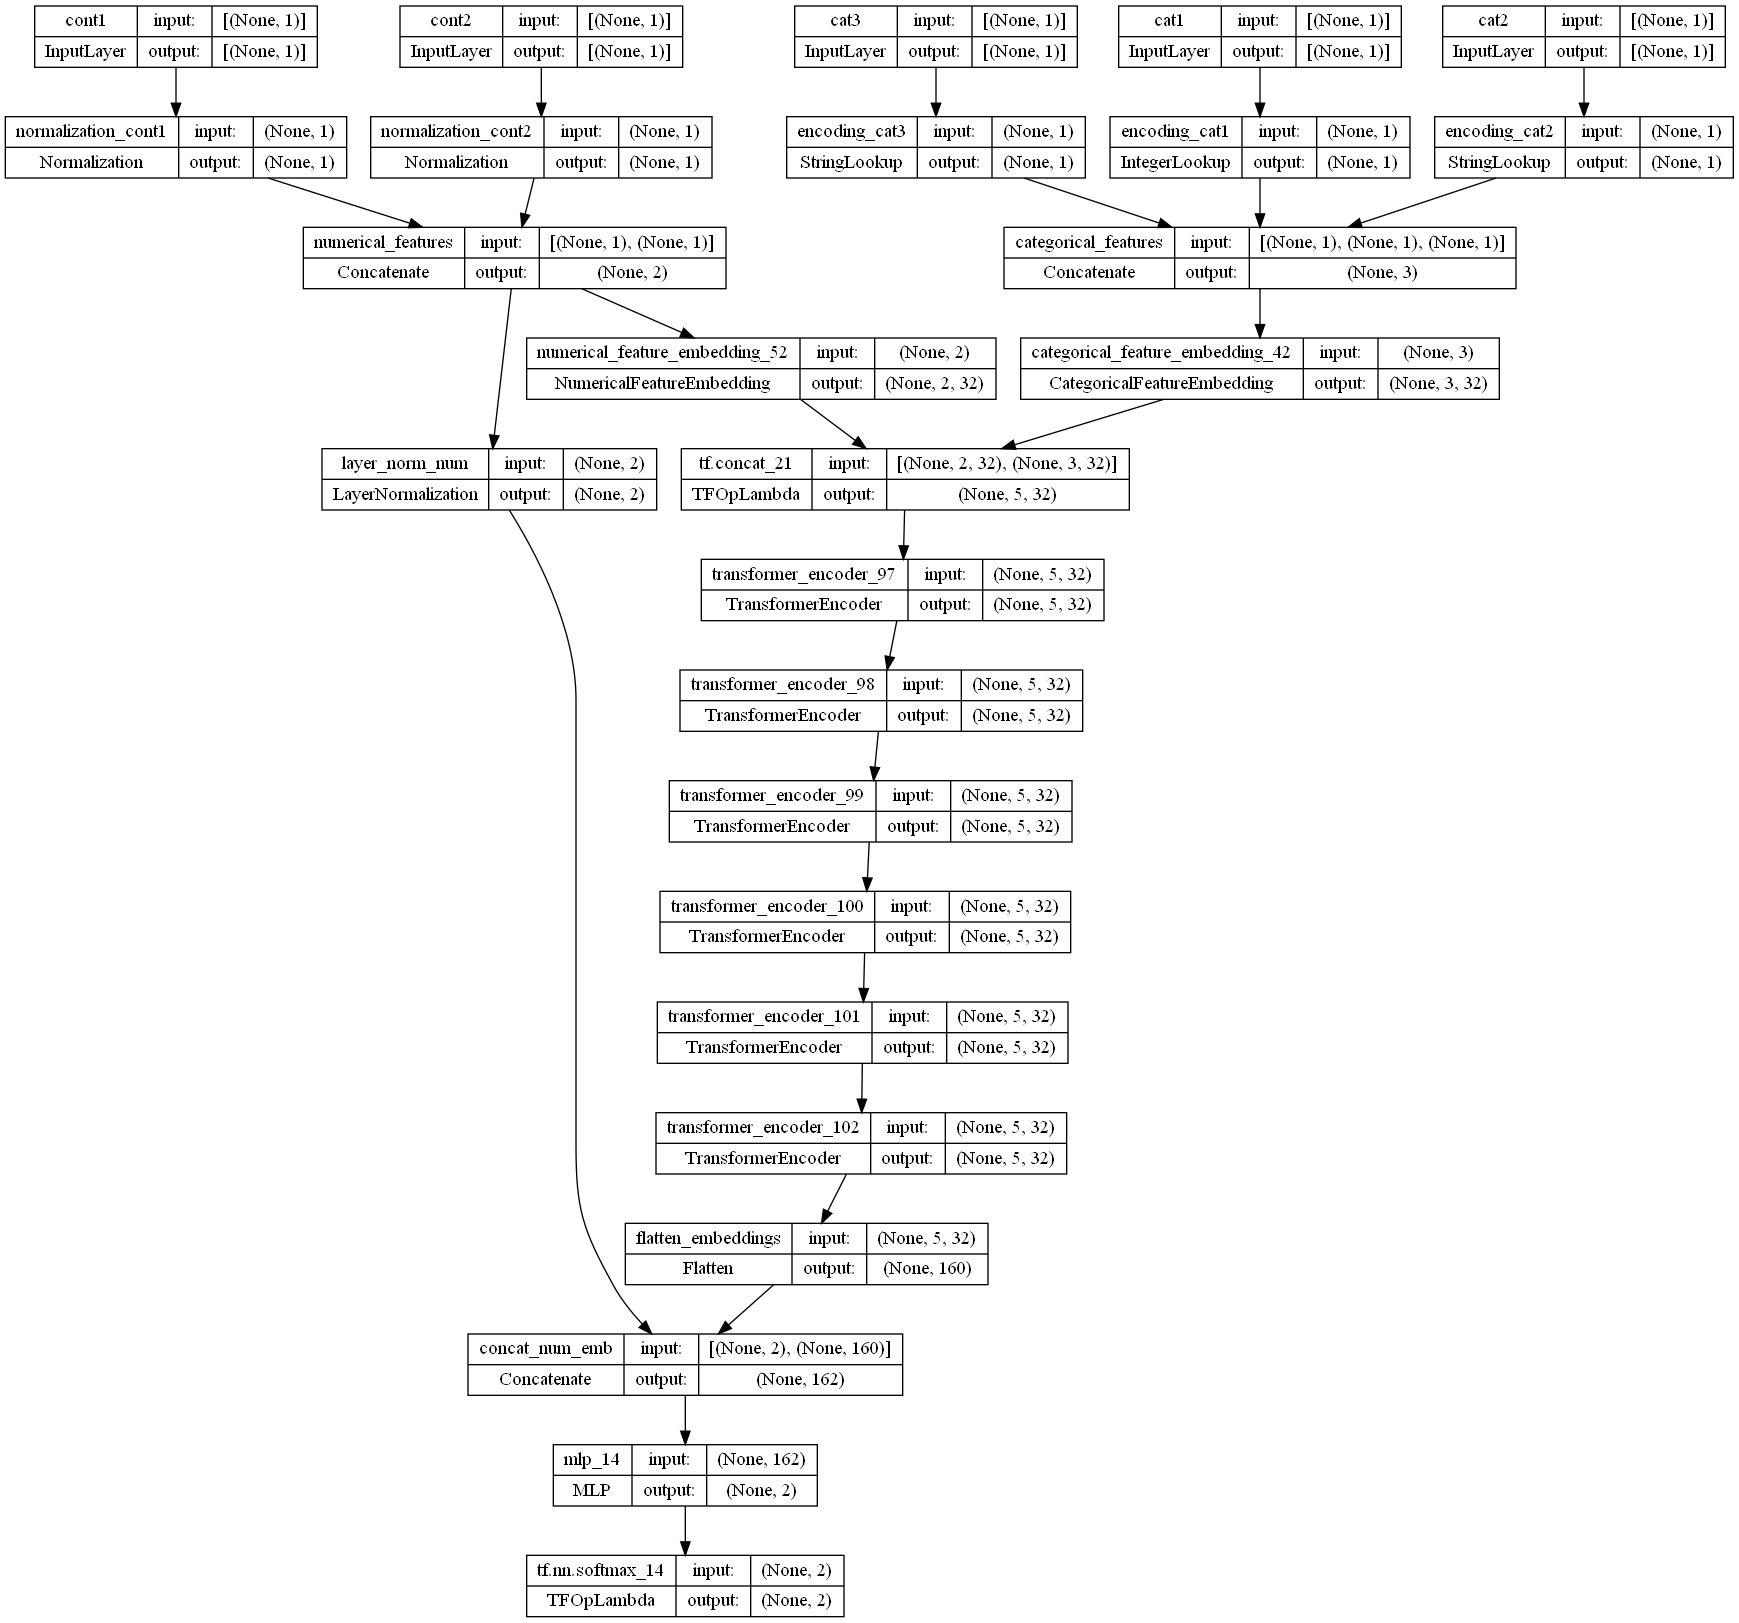

In [299]:
tf.keras.utils.plot_model(tt.model, 
to_file='../data/model.png' ,
show_shapes=True
)

In [300]:
tt.predict(X.sample(10))

1/1 [==============================] - 1s 891ms/step


array([[0.31129545, 0.6887046 ],
       [0.31137478, 0.6886252 ],
       [0.29190525, 0.7080948 ],
       [0.38640603, 0.61359394],
       [0.19555646, 0.80444354],
       [0.2714985 , 0.7285015 ],
       [0.26286066, 0.7371394 ],
       [0.29953212, 0.7004679 ],
       [0.32308272, 0.67691725],
       [0.3117412 , 0.68825877]], dtype=float32)

In [310]:
tt.evaluate(X.iloc[:20], y.iloc[:20])

1/1 [==============================] - 0s 29ms/step - loss: 0.9040 - accuracy: 0.4000


[0.9040449857711792, 0.4000000059604645]

In [204]:
# https://epistasislab.github.io/
from pmlb import fetch_data

data = fetch_data('adult')

In [215]:
target_column = ['target']
categorical_features = data.drop(columns=target_column).select_dtypes(include=np.int64).columns.to_list()
numeric_features = data.select_dtypes(include=np.float64).columns.to_list()

features = data[numeric_features+categorical_features].copy()
target = data[target_column].copy()

categorical_features
for feat in categorical_features:
    if features[feat].nunique()>10:
        features.loc[:,feat] = features.loc[:,feat].apply(lambda x: f"{feat}_{x}")


In [222]:
tt = TabularTransformer()


In [223]:
tt.fit(features, target, batch_size=128, epochs=5)

Epoch 1/5
344/344 [==============================] - 80s 211ms/step - loss: 0.3482 - accuracy: 0.8350 - val_loss: 0.2940 - val_accuracy: 0.8626
Epoch 2/5
344/344 [==============================] - 74s 215ms/step - loss: 0.3206 - accuracy: 0.8504 - val_loss: 0.2883 - val_accuracy: 0.8669
Epoch 3/5
344/344 [==============================] - 77s 223ms/step - loss: 0.3146 - accuracy: 0.8532 - val_loss: 0.2870 - val_accuracy: 0.8667
Epoch 4/5
344/344 [==============================] - 74s 216ms/step - loss: 0.3108 - accuracy: 0.8562 - val_loss: 0.2841 - val_accuracy: 0.8659
Epoch 5/5
344/344 [==============================] - 85s 247ms/step - loss: 0.3097 - accuracy: 0.8552 - val_loss: 0.2845 - val_accuracy: 0.8684


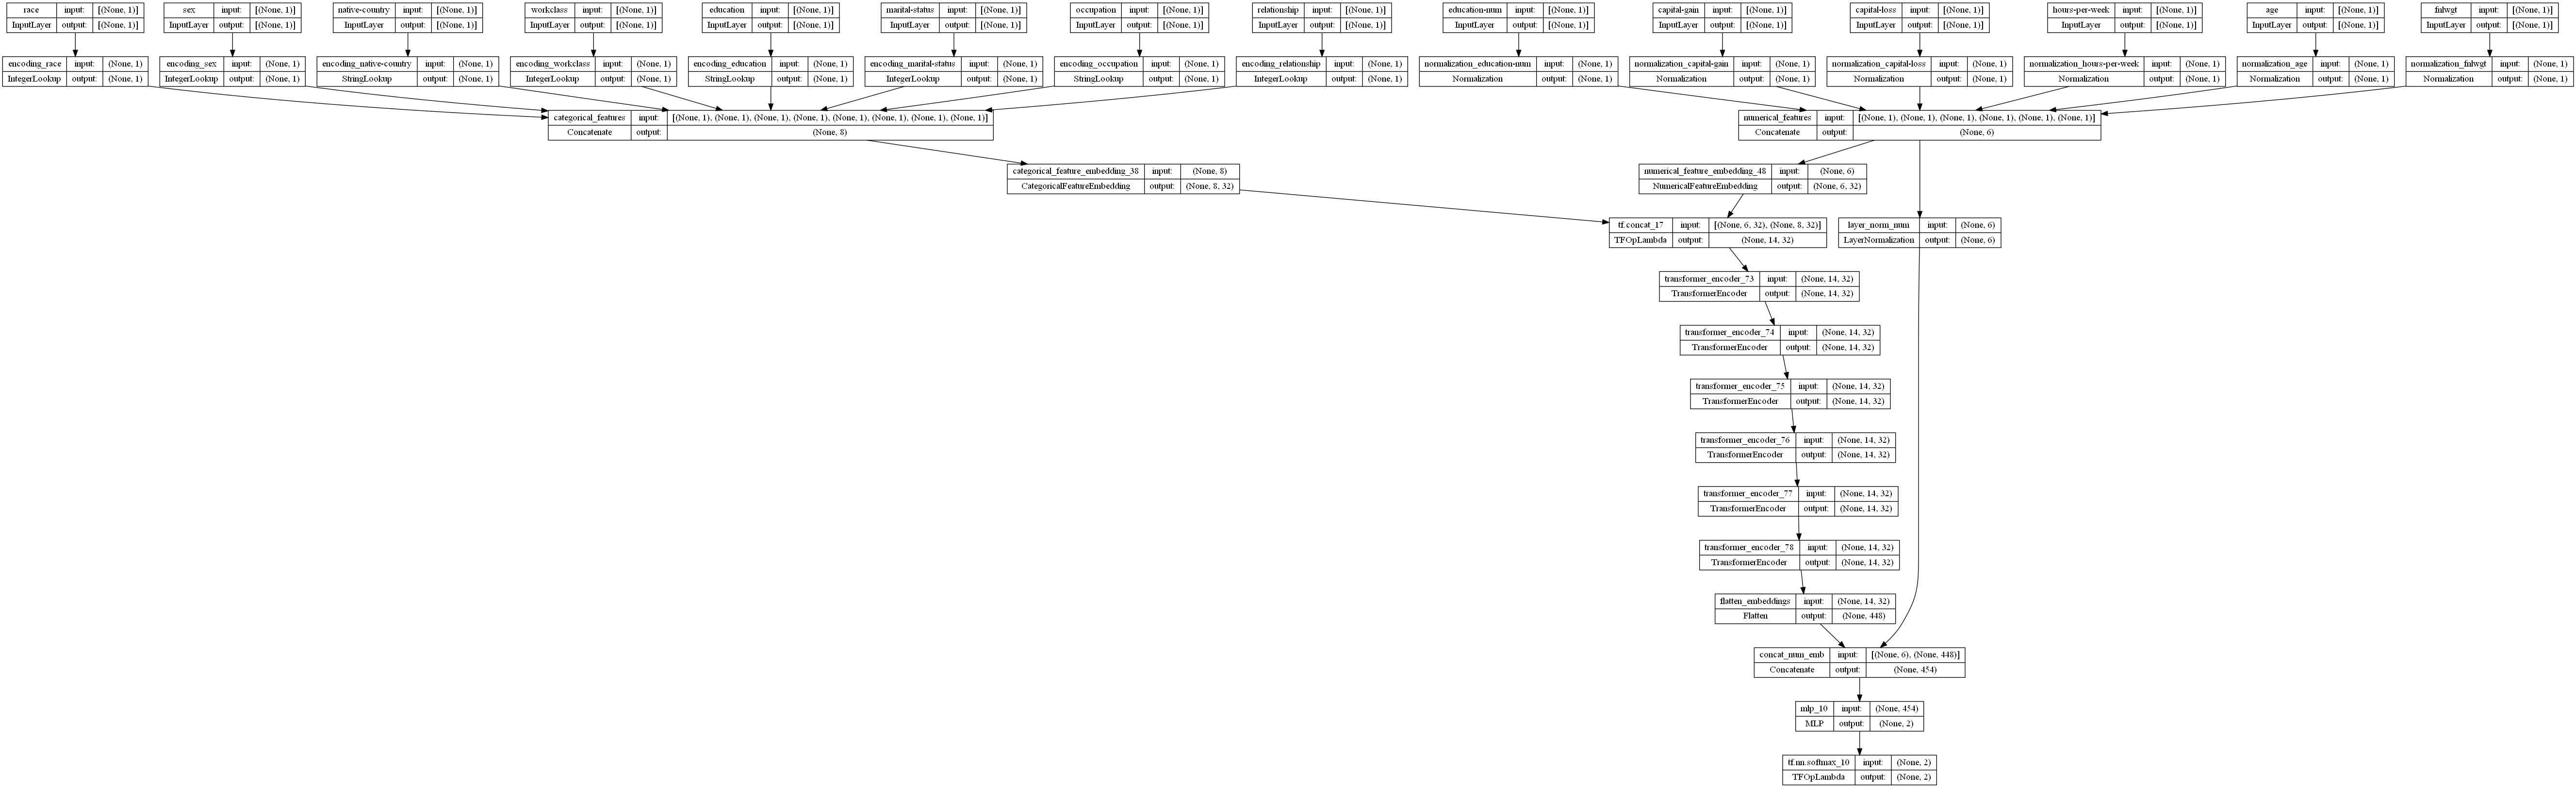

In [217]:
tf.keras.utils.plot_model(tt.model, 
    show_shapes=True
)

In [242]:
# y_true = np.array([[0,1], [1,0], [1,0], [1,0]])
# y_pred = np.array([[0.2,0.8], [0.7,0.3], [0.3,0.7], [0.1,0.9]])

# y_true=tf.argmax(y_true ,axis=-1)
# y_pred=tf.argmax(y_pred ,axis=-1)
# # y_true.shape


# # y_true = tf.cast(y_true, tf.bool)
# # y_pred = tf.cast(y_pred, tf.bool)

# y_true == y_pred
# # y_pred
# # tf.round(tf.clip_by_value(y_true * y_pred, 0, 1))

# recall = true_positives / (all_positives + K.epsilon())

In [ ]:
# def recall(y_true, y_pred):
#     y_true = tf.ones_like(y_true) 
#     true_positives = tf.sum(tf.round(tf.clip(y_true * y_pred, 0, 1)))
#     all_positives = tf.sum(tf.round(tf.clip(y_true, 0, 1)))
    
#     recall = true_positives / (all_positives + K.epsilon())
#     return recall

# def precision(y_true, y_pred):
#     y_true = tf.ones_like(y_true) 
#     true_positives = tf.sum(tf.round(tf.clip(y_true * y_pred, 0, 1)))
    
#     predicted_positives = tf.sum(K.round(tf.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + tf.epsilon())
#     return precision